In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import string
from underthesea import word_tokenize
from gensim.models import FastText
from deep_translator import GoogleTranslator
import random
import os
import re

In [2]:
df = pd.read_csv('..\\..\\data\\processed\\data_nganhang.csv')
df.head()

,Date,Words,Near,Mid,Far
0,2022-01-04,"['Satoshi Nakamoto', 'khai thác', 'khối', 'Khố...",0.0,0.0,1.0
1,2022-01-04,"['Chiều', 'Quốc hội', 'thảo luận', 'tổ', 'dự t...",0.0,0.0,1.0
2,2022-01-04,"['đồng bạc', 'xanh', 'JPY mức', 'lợi suất', 'đ...",0.0,0.0,1.0
3,2022-01-04,"['Phiên', 'giao dịch', 'đầu', 'chứng kiến', 's...",0.0,0.0,1.0
4,2022-01-04,"['Phân phối', 'bảo hiểm', 'nhân thọ', 'kênh', ...",0.0,0.0,1.0


In [3]:
df = df.groupby('Date')[['Near', 'Mid', 'Far']].first()
df = df.reset_index()

In [4]:
df.head()

,Date,Near,Mid,Far
0,2022-01-04,0.0,0.0,1.0
1,2022-01-05,0.0,0.0,1.0
2,2022-01-06,0.0,0.0,1.0
3,2022-01-07,0.0,1.0,1.0
4,2022-01-10,0.0,1.0,1.0


In [5]:
data_dirty = pd.read_csv('..\\..\\data\\raw\\tai_chinh_ngan_hang.csv').dropna()
data_dirty.head(2)

,Unnamed: 0,Title,Text,Key Word,Published_Date,Source
0,0,"Từ hôm nay (8/8), mua vàng SJC phải mất 3 - 5 ...",Ảnh minh họa\n\nNgân hàng TMCP Ngoại Thương Vi...,"triệu, từ, miếng, khách, mua, giao, để, tất, n...",2024-08-08 11:48:00,https://cafef.vn
1,1,Hai ngân hàng bất ngờ quay đầu giảm lãi suất t...,Ngân hàng SeABank vừa bất ngờ giảm đồng loạt 0...,"ngờ, kỳ, tiết, tháng, kiệm, giảm, đầu, suất, h...",2024-08-08 06:38:00,https://cafef.vn


In [6]:
data_dirty['Date'] = pd.to_datetime(data_dirty['Published_Date']).dt.date
data_gr = data_dirty.groupby('Date')['Text'].apply(''.join).reset_index()
data_gr.head()

,Date,Text
0,2022-01-01,Ngân hàng Bản Việt vừa phát đi thông tin cho b...
1,2022-01-02,Trong báo cáo Chiến lược đầu tư năm 2022 mới c...
2,2022-01-03,Hầu hết các tiền tệ Châu Á kết thúc năm 2021 v...
3,2022-01-04,"Vào ngày 3 tháng 1 năm 2009, Satoshi Nakamoto ..."
4,2022-01-05,Ngân hàng Nhà nước vừa công bố kết quả điều tr...


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
data_gr['Date'] = pd.to_datetime(data_gr['Date'])
data = df.merge(data_gr[['Date', 'Text']], on='Date')
data.shape

(647, 5)

In [8]:
data.head(2)

,Date,Near,Mid,Far,Text
0,2022-01-04,0.0,0.0,1.0,"Vào ngày 3 tháng 1 năm 2009, Satoshi Nakamoto ..."
1,2022-01-05,0.0,0.0,1.0,Ngân hàng Nhà nước vừa công bố kết quả điều tr...


In [9]:
data['Score'] = data['Near'] + data['Mid'] * 2 + data['Far'] * 3

def labeled(score):
    if score < 2:
        return 'Low'
    if score < 5:
        return 'Mid'
    return "High"

data['Potential'] = data['Score'].apply(labeled)

In [10]:
data.head(2)

,Date,Near,Mid,Far,Text,Score,Potential
0,2022-01-04,0.0,0.0,1.0,"Vào ngày 3 tháng 1 năm 2009, Satoshi Nakamoto ...",3.0,Mid
1,2022-01-05,0.0,0.0,1.0,Ngân hàng Nhà nước vừa công bố kết quả điều tr...,3.0,Mid


# Data Augmentation

In [11]:

from concurrent.futures import ThreadPoolExecutor
import time

# Dịch ngược với Deep Translator
def back_translation_deep_translator(doc):
    translator = GoogleTranslator(source='auto', target='en')
    back_translator = GoogleTranslator(source='en', target='vi')

    def translate_text(text, max_retries=10, delay=1):
        for attempt in range(max_retries):
            try:
                translated = translator.translate(text)
                back_translated = back_translator.translate(translated)
                return back_translated
            except Exception as e:
                time.sleep(delay)
                
        print('Không thể dịch')
        return text

    chunk_size = 1000
    if len(doc) > chunk_size:
        chunks = [doc[i:i + chunk_size] for i in range(0, len(doc), chunk_size)]
        results = [translate_text(chunk) for chunk in chunks]
        return ' '.join(results)
    else:
        return translate_text(doc)


# Thay thế từ đồng nghĩa
def synonym_replacement(doc, synonym_dict):
    tokens = word_tokenize(doc)
    new_tokens = []
    for word in tokens:
        if word.lower() in synonym_dict:
            if synonym_dict[word.lower()]:
                new_tokens.append(random.choice(list(synonym_dict[word.lower()])))
            else:
                new_tokens.append(word.lower())
        else:
            new_tokens.append(word)
    return ' '.join(new_tokens)


# Tăng cường dữ liệu
def augmentation_text(data, synonym_dict, num_new_texts, max_workers = 10):
    augmented_docs = []
    index_labels = []
    
    
    for label in data['Potential'].unique():
        label_data = data[data['Potential'] == label]
        
        def process_document(idx):
            doc = data.loc[idx, 'Text']
            new_doc = synonym_replacement(doc, synonym_dict)
            #new_doc = back_translation_deep_translator(new_doc)
            return new_doc
        
        indices = [random.choice(label_data.index) for _ in range(num_new_texts)]
        index_labels.append(indices)
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(process_document, indices))
        
        augmented_docs.extend(results)
    
    return augmented_docs, index_labels


In [12]:
# tạo thư viện từ đồng nghĩa
def create_synonyms_dict(directory):
    synonyms_dict = {}

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    for line in file:
                        line = line.strip()
                        if line:  
                            synonyms = line.split(',') 

                            if len(synonyms) == 1:
                                continue

                            for word in synonyms:
                                word = word.strip()
                                if word:
                                    if word not in synonyms_dict:
                                        synonyms_dict[word] = set()
                                    synonyms_dict[word].update(synonym.strip() for synonym in synonyms if synonym.strip() != word)
            except Exception as e:
                print(f"Lỗi {e}")

    return synonyms_dict

In [14]:


translator = GoogleTranslator()
directory = '..\\..\\vi-wordnet'
synonyms_dict = create_synonyms_dict(directory)
num_new_texts = 1000
max_worker = 50
new_acticles = augmentation_text(data, synonyms_dict, num_new_texts=num_new_texts, max_workers=max_worker)


In [15]:
documents = list(data['Text'].values)
documents.extend(new_acticles[0])

In [47]:
flat_array = np.array(new_acticles[1]).flatten()
labels_potential = list(data['Potential'].values)
labels_potential.extend(data.loc[flat_array, 'Potential'])

In [17]:
labels_near = list(data['Near'].values)
labels_near.extend(data.loc[flat_array, 'Near'])

In [18]:
labels_mid = list(data['Mid'].values)
labels_mid.extend(data.loc[flat_array, 'Mid'])

In [19]:
labels_far = list(data['Far'].values)
labels_far.extend(data.loc[flat_array, 'Far'])

<BarContainer object of 2 artists>

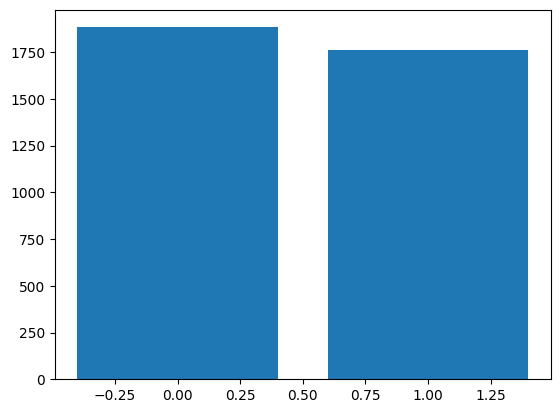

In [26]:
plt.bar(np.unique(labels_near, return_counts=True)[0], np.unique(labels_near, return_counts=True)[1])

# Processing

In [21]:
def load_stopwords(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        return set(file.read().splitlines())

vietnamese_stopwords = load_stopwords("..\\..\\data\\raw\\vietnamese-stopwords.txt")

def remove_punctuation(text):
    return text.translate(str.maketrans(' ', ' ', string.punctuation))

def delete_stopwords_and_clean(doc):
    
    tokens = word_tokenize(remove_punctuation(doc))
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in vietnamese_stopwords and not word.lower().startswith('http')]
    
    # Loại bỏ ký tự đặc biệt và số 
    processed_words = [re.sub(r'[^\w\s]', ' ', word).strip() for word in filtered_tokens if not re.search(r'\d', word)]
    # Loại bỏ '\t', '\n', ...
    processed_words = [re.sub(r'\s+', ' ', word).strip() for word in processed_words if word]

    seen = set()
    unique_words = []
    for word in processed_words:
        if word not in seen and word != ' ':
            unique_words.append(word)
            seen.add(word)

    return unique_words



In [22]:
processed_docs = [delete_stopwords_and_clean(doc) for doc in documents]

In [29]:
df = pd.DataFrame({'Text': documents, 'Words': processed_docs, 'Potential': labels_potential, 'Near' : labels_near, 'Mid' : labels_mid, 'Far': labels_far})
df.head(2)

,Text,Words,Potential,Near,Mid,Far
0,"Vào ngày 3 tháng 1 năm 2009, Satoshi Nakamoto ...","[satoshi nakamoto, khai thác, khối, khối genes...",Mid,0.0,0.0,1.0
1,Ngân hàng Nhà nước vừa công bố kết quả điều tr...,"[ngân hàng, nhà nước, công bố, kết quả, điều t...",Mid,0.0,0.0,1.0


In [30]:
df.to_csv('augmentation_data.csv')

In [23]:
model_fast = FastText(sentences=processed_docs, vector_size=50, window=5, min_count=1, workers=4)

def get_document_vector1(doc, model):
    vectors = [model.wv[word] for word in doc if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

document_vectors_fast = np.array([get_document_vector1(doc, model_fast) for doc in processed_docs])

# Model

In [42]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, classification_report



In [52]:
def train_bilstm_model(labels, processed_docs, model_fast, max_length=50, batch_size=64, epochs=20):
    # Encode labels for multi-class classification
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)
    num_classes = len(label_encoder.classes_) 
    y = to_categorical(y_encoded, num_classes=num_classes) 

    X_train, X_test, y_train, y_test = train_test_split(processed_docs, y, test_size=0.2, random_state=42)

    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    vocab_size = len(tokenizer.word_index) + 1

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

    
    embedding_dim = model_fast.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if word in model_fast.wv:
            embedding_matrix[i] = model_fast.wv[word]
        else:
            embedding_matrix[i] = np.zeros(embedding_dim)

    model_bilstm = Sequential()
    model_bilstm.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_length, 
                        trainable=False))

    model_bilstm.add(Bidirectional(LSTM(24, return_sequences=False, kernel_regularizer=l2(0.02))))
    model_bilstm.add(Dropout(0.2)) 
    model_bilstm.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.02))) 

    model_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model_bilstm.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test))

    y_pred = model_bilstm.predict(X_test_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)  
    y_true = np.argmax(y_test, axis=1) 

    print(classification_report(y_true, y_pred_classes))

    return model_bilstm

In [53]:
train_bilstm_model(labels_near, processed_docs, model_fast)

Epoch 1/20
46/46 [==============================] - 4s 33ms/step - loss: 2.8213 - accuracy: 0.4933 - val_loss: 2.2639 - val_accuracy: 0.5192
Epoch 2/20
46/46 [==============================] - 1s 19ms/step - loss: 1.8942 - accuracy: 0.5423 - val_loss: 1.5800 - val_accuracy: 0.5329
Epoch 3/20
46/46 [==============================] - 1s 19ms/step - loss: 1.3643 - accuracy: 0.5711 - val_loss: 1.2012 - val_accuracy: 0.5493
Epoch 4/20
46/46 [==============================] - 1s 20ms/step - loss: 1.0725 - accuracy: 0.5931 - val_loss: 0.9915 - val_accuracy: 0.5712
Epoch 5/20
46/46 [==============================] - 1s 27ms/step - loss: 0.9134 - accuracy: 0.6058 - val_loss: 0.8763 - val_accuracy: 0.5904
Epoch 6/20
46/46 [==============================] - 1s 27ms/step - loss: 0.8215 - accuracy: 0.6116 - val_loss: 0.8120 - val_accuracy: 0.5808
Epoch 7/20
46/46 [==============================] - 1s 23ms/step - loss: 0.7657 - accuracy: 0.6459 - val_loss: 0.7712 - val_accuracy: 0.6205
Epoch 8/20
46

In [1]:
train_bilstm_model(labels_mid, processed_docs, model_fast)

NameError: name 'train_bilstm_model' is not defined

In [ ]:
train_bilstm_model(labels_far, processed_docs, model_fast)

Epoch 1/20
46/46 [==============================] - 6s 43ms/step - loss: 1.8383 - accuracy: 0.5022 - val_loss: 1.5695 - val_accuracy: 0.5521
Epoch 2/20
46/46 [==============================] - 1s 24ms/step - loss: 1.3921 - accuracy: 0.5701 - val_loss: 1.2472 - val_accuracy: 0.5671
Epoch 3/20
46/46 [==============================] - 1s 26ms/step - loss: 1.1324 - accuracy: 0.6006 - val_loss: 1.0464 - val_accuracy: 0.5740
Epoch 4/20
46/46 [==============================] - 1s 32ms/step - loss: 0.9670 - accuracy: 0.6205 - val_loss: 0.9469 - val_accuracy: 0.5808
Epoch 5/20
46/46 [==============================] - 1s 23ms/step - loss: 0.8704 - accuracy: 0.6346 - val_loss: 0.8530 - val_accuracy: 0.5918
Epoch 6/20
46/46 [==============================] - 1s 20ms/step - loss: 0.7953 - accuracy: 0.6603 - val_loss: 0.7970 - val_accuracy: 0.6301
Epoch 7/20
46/46 [==============================] - 1s 26ms/step - loss: 0.7499 - accuracy: 0.6733 - val_loss: 0.7704 - val_accuracy: 0.6288
Epoch 8/20
46